# Monitoramente Inteligente da Demanda de Transporte Público na Cidade Universitária da USP
## Notebook para visualização dos resultados

Este notebook aborda o fluxo de extração, tratamento, visualização e avaliação dos resultados obtidos com o processamento de imagem realizado pela Yolov8 e armazenados na tabela DynamoDB. Ele está organizado nas seguintes seções:

- Configurações de ambiente: definição da região AWS e nome da tabela e instanciação do DynamoDB.
- Funções auxiliares: leitura completa da tabela (`scan_itens`) e conversão de tipos Decimal para int/float (`converte_campos`).
- Carregamento e pré-processamento: varredura da tabela, conversão de campos e criação do DataFrame Pandas `df`.
- Visualizações: gráficos de quantidade de pessoas e nível de bateria ao longo do tempo.
- Métricas: cálculo do MAE absoluto e percentual para a quantidade de pessoas detectadas nas fotos. 

### Configurações de ambiente

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error
from decimal import Decimal

In [2]:
TABLE_NAME = 'yolo-resultados'
REGION = 'sa-east-1' 

In [3]:
dynamodb = boto3.resource('dynamodb', region_name=REGION)
tabela = dynamodb.Table(TABLE_NAME)

### Funções auxiliares

In [4]:
def scan_itens(tabela):
    """
    Realiza a varredura completa da tabela DynamoDB e retorna todos os itens.
    
    Parâmetros: 
    tabela: Objeto da tabela DynamoDB.
    """
    itens = []
    resp = tabela.scan()
    itens.extend(resp.get("Items", []))
    while "LastEvaluatedKey" in resp:
        resp = tabela.scan(ExclusiveStartKey=resp["LastEvaluatedKey"])
        itens.extend(resp.get("Items", []))
    return itens

In [5]:
def converte_campos(itens):
    """
    Converte campos específicos dos itens do DynamoDB de Decimal para tipos nativos do Python.
    
    Parâmetros:
    itens: Lista de itens retirados do DynamoDB.
    """
    for item in itens:
        if "qtd_pessoas" in item and isinstance(item["qtd_pessoas"], Decimal): 
            item["qtd_pessoas"] = int(item["qtd_pessoas"])
        if "bateria" in item and isinstance(item["bateria"], Decimal):
            item["bateria"] = float(item["bateria"])
    return itens

## Carregamento e tratamento dos dados

Carregando dados do DynamoDB

In [6]:
itens = scan_itens(tabela)
print(f"Itens carregados: {len(itens)}")

Itens carregados: 45


In [7]:
itens[0]

{'hora_execucao': '2025-12-08T00:38:32.661076-03:00',
 'qtd_pessoas': Decimal('2'),
 'outputKey': 'resultados/out_20251203T141622.jpg',
 'hora_imagem': '2025-12-03T11:16:18',
 'imagem': 'uploads/2025-12-03/20251203T141622.jpg',
 'bateria': Decimal('3.759264')}

Conversão de Decimal para inteiro ou float

In [8]:
itens = converte_campos(itens)

In [9]:
itens[0]

{'hora_execucao': '2025-12-08T00:38:32.661076-03:00',
 'qtd_pessoas': 2,
 'outputKey': 'resultados/out_20251203T141622.jpg',
 'hora_imagem': '2025-12-03T11:16:18',
 'imagem': 'uploads/2025-12-03/20251203T141622.jpg',
 'bateria': 3.759264}

Criando um DataFrame a partir dos dados obtidos

In [10]:
df = pd.DataFrame(itens)

In [11]:
df.head()

,hora_execucao,qtd_pessoas,outputKey,hora_imagem,imagem,bateria
0,2025-12-08T00:38:32.661076-03:00,2,resultados/out_20251203T141622.jpg,2025-12-03T11:16:18,uploads/2025-12-03/20251203T141622.jpg,3.759264
1,2025-12-08T00:38:36.085476-03:00,1,resultados/out_20251203T144925.jpg,2025-12-03T11:49:19,uploads/2025-12-03/20251203T144925.jpg,3.728691
2,2025-12-08T00:38:31.406920-03:00,2,resultados/out_20251203T140422.jpg,2025-12-03T11:04:19,uploads/2025-12-03/20251203T140422.jpg,3.762933
3,2025-12-08T00:38:25.089695-03:00,6,resultados/out_20251203T130428.jpg,2025-12-03T10:04:18,uploads/2025-12-03/20251203T130428.jpg,3.755595
4,2025-12-08T00:38:27.496692-03:00,0,resultados/out_20251203T132829.jpg,2025-12-03T10:28:18,uploads/2025-12-03/20251203T132829.jpg,3.794729


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hora_execucao  45 non-null     object 
 1   qtd_pessoas    45 non-null     int64  
 2   outputKey      45 non-null     object 
 3   hora_imagem    45 non-null     object 
 4   imagem         45 non-null     object 
 5   bateria        45 non-null     float64
dtypes: float64(1), int64(1), object(4)
memory usage: 2.2+ KB


Salvando o DataFrame como .csv

In [13]:
df.to_csv('tabela_resultados.csv', index=False)

### Visualizações Gráficas

Ordenando pelo horário das fotos

In [14]:
df["hora_imagem_convertido"] = pd.to_datetime(df["hora_imagem"], errors="coerce", format="ISO8601")
df["data"] = df["hora_imagem_convertido"].dt.date
df["horario"] = df["hora_imagem_convertido"].dt.time
df = df.set_index('hora_imagem').sort_index()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 2025-12-03T09:49:18 to 2025-12-03T12:01:18
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   hora_execucao           45 non-null     object        
 1   qtd_pessoas             45 non-null     int64         
 2   outputKey               45 non-null     object        
 3   imagem                  45 non-null     object        
 4   bateria                 45 non-null     float64       
 5   hora_imagem_convertido  45 non-null     datetime64[ns]
 6   data                    45 non-null     object        
 7   horario                 45 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 3.2+ KB


In [16]:
df.head()

,hora_execucao,qtd_pessoas,outputKey,imagem,bateria,hora_imagem_convertido,data,horario
hora_imagem,,,,,,,,
2025-12-03T09:49:18,2025-12-08T00:38:23.452676-03:00,4,resultados/out_20251203T124925.jpg,uploads/2025-12-03/20251203T124925.jpg,3.848537,2025-12-03 09:49:18,2025-12-03,09:49:18
2025-12-03T09:52:19,2025-12-08T00:38:23.875219-03:00,6,resultados/out_20251203T125226.jpg,uploads/2025-12-03/20251203T125226.jpg,3.827748,2025-12-03 09:52:19,2025-12-03,09:52:19
2025-12-03T09:55:19,2025-12-08T00:38:24.169669-03:00,5,resultados/out_20251203T125528.jpg,uploads/2025-12-03/20251203T125528.jpg,3.842423,2025-12-03 09:55:19,2025-12-03,09:55:19
2025-12-03T09:58:18,2025-12-08T00:38:24.472711-03:00,3,resultados/out_20251203T125828.jpg,uploads/2025-12-03/20251203T125828.jpg,3.839977,2025-12-03 09:58:18,2025-12-03,09:58:18
2025-12-03T10:01:19,2025-12-08T00:38:24.778261-03:00,0,resultados/out_20251203T130126.jpg,uploads/2025-12-03/20251203T130126.jpg,3.795952,2025-12-03 10:01:19,2025-12-03,10:01:19


#### Gráfico de quantidade de pessoas ao longo do tempo

Quantidade de pessoas identificadas nas fotos (contagem realizada manualmente):

In [17]:
rotulos = [ 
    5, 7, 6, 6, 4, 6, 4, 5, 3, 2, 3, 1, 1, 1, 1, 2, 2, 1, 1, 3, 6, 2, 3, 
    3, 5, 2, 1, 2, 0, 3, 2, 0, 0, 0, 2, 3, 6, 7, 4, 7, 2, 6, 5, 5, 6
]

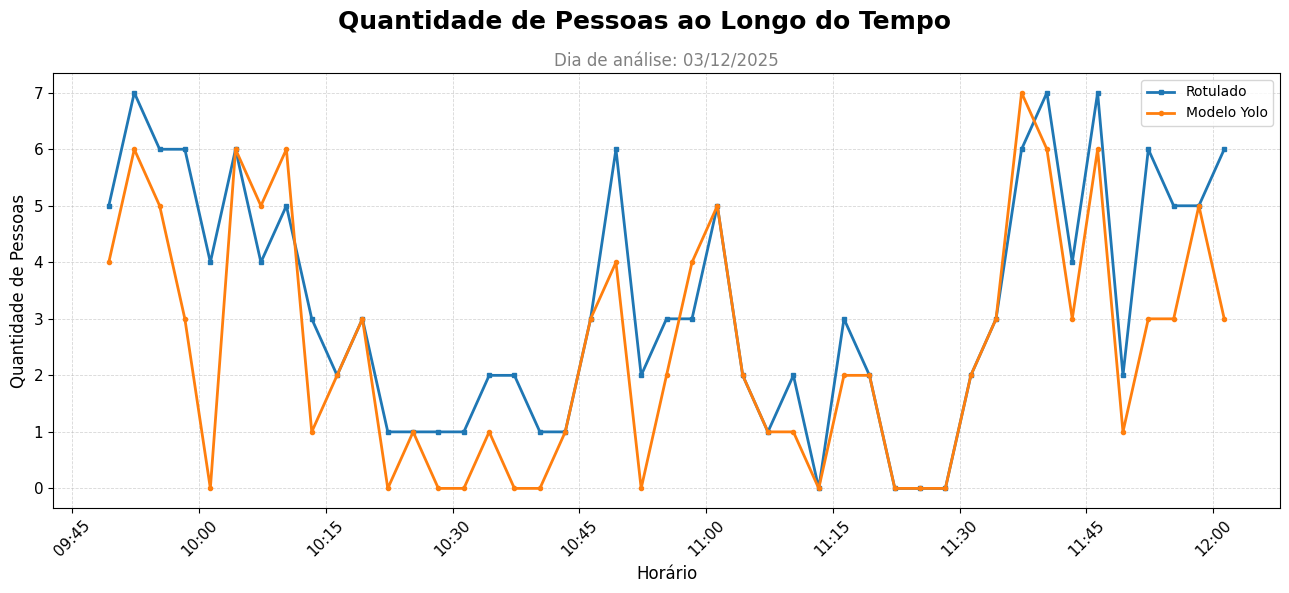

In [18]:
fig, ax = plt.subplots(figsize=(13, 6))
# Linha dos valores rotulados
ax.plot(
    df["hora_imagem_convertido"],
    rotulos,
    linewidth=2,
    marker="s",
    markersize=3,
    label="Rotulado"
)
# Linha dos valores preditos
ax.plot(
    df["hora_imagem_convertido"],
    df["qtd_pessoas"],
    linewidth=2,
    marker="o",
    markersize=3,
    label="Modelo Yolo"
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)

fig.suptitle(
    "Quantidade de Pessoas ao Longo do Tempo",
    fontsize=18,
    fontweight="bold",
    y=0.98
)

ax.set_title(
    "Dia de análise: 03/12/2025",
    fontsize=12,
    color="gray",
    pad=5
)
ax.set_xlabel("Horário", fontsize=12)
ax.set_ylabel("Quantidade de Pessoas", fontsize=12)

ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


#### Gráfico da tensão de bateria ao longo do tempo

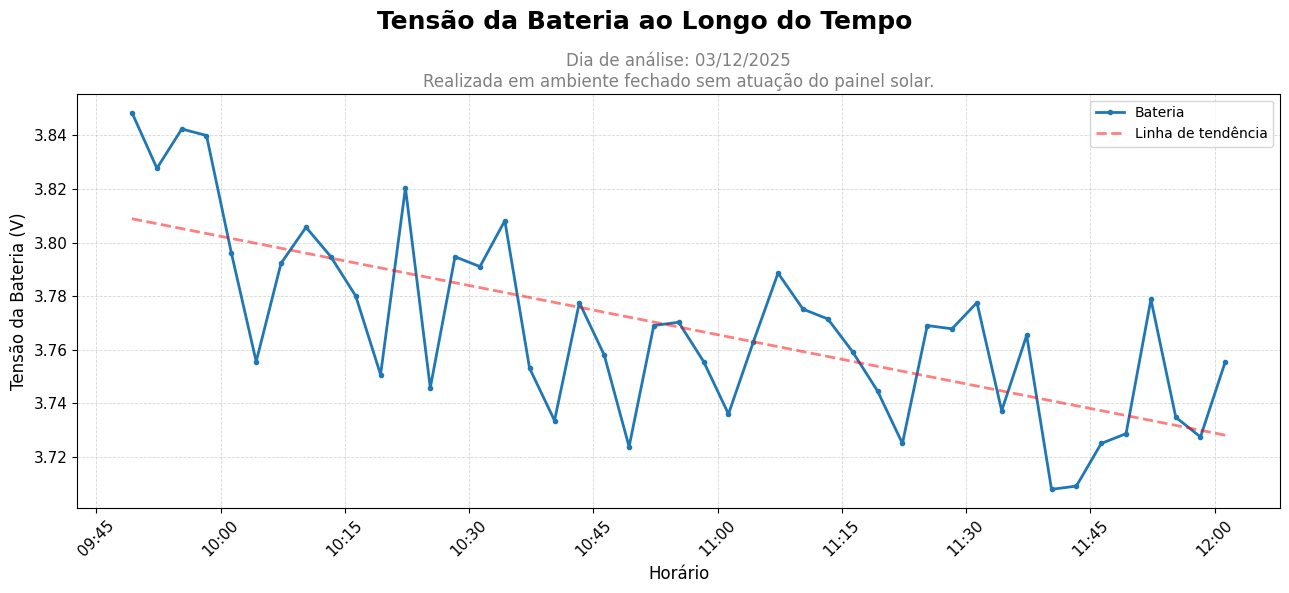

In [19]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(
    df["hora_imagem_convertido"],
    df["bateria"],
    linewidth=2,
    marker="o",
    markersize=3,
    label='Bateria'
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)

# Linha de tendência
x_num = mdates.date2num(df["hora_imagem_convertido"])
coef = np.polyfit(x_num, df["bateria"], 1)
tend = np.poly1d(coef)
ax.plot(
    df["hora_imagem_convertido"],
    tend(x_num),
    linestyle="--",
    linewidth=2,
    color="red",
    alpha=0.5,
    label="Linha de tendência"
)


fig.suptitle(
    "Tensão da Bateria ao Longo do Tempo",
    fontsize=18,
    fontweight="bold",
    y=0.98
)

ax.set_title(
    "Dia de análise: 03/12/2025\n" \
    "Realizada em ambiente fechado sem atuação do painel solar.",
    fontsize=12,
    color="gray",
    pad=5
)
ax.set_xlabel("Horário", fontsize=12)
ax.set_ylabel("Tensão da Bateria (V)", fontsize=12)

ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


## Métricas 

As métricas aqui foram utilizadas para mensurar o quanto o modelo YOLOv8 conseguiu identificar adequadamente as pessoas nas fotos. 



Primeiro, calculamos o MAE (Mean Absolute Error), que mede o erro médio absoluto entre os valores previstos e os valores reais. Essa métrica é intuitiva e mostra, em média, quantas unidades o modelo erra em cada previsão.

Em seguida, calculamos o MAE Percentual, que expressa esse erro em forma de porcentagem. Essa abordagem facilita a interpretação quando queremos entender o impacto relativo do erro em relação ao total observado.

Essas métricas fornecem uma visão geral da precisão do modelo e servem como base para comparações e melhorias futuras.

In [20]:
y_rotulos = np.array(rotulos)
y_pred = np.array(df["qtd_pessoas"])
mae = mean_absolute_error(y_rotulos, y_pred)

print(f"MAE (Mean Absolute Error): {mae:.4f}")

MAE (Mean Absolute Error): 0.9333


Com isso, observa-se que, em média, a YOLOv8 erra 0,9333 pessoas por imagem. Ou seja, aproximadamente 1 pessoa por foto. 